<a href="https://colab.research.google.com/github/soumaya287/ATLAS/blob/main/Copy_of_Unet_model_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Referring Code From: https://github.com/rohan-paul/MachineLearning-DeepLearning-Code-for-my-YouTube-Channel/blob/master/Computer_Vision/Unet-Brain-MRI-Segmentation-Tensorflow-Keras/Unet-Brain-MRI-Segmentation-Tensorflow-Keras.ipynb
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

import cv2
from tqdm import tqdm_notebook, tnrange
from glob import glob
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf
from skimage.color import rgb2gray
from tensorflow.keras import Input
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from utils import *
from unet import *

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Setting size parameters of images
im_width = 256
im_height = 256

# Loading the image and mask paths

In [ ]:
image_filenames_train= glob('/content/drive/MyDrive/data/test/images/*')
# creating a list of all files containing the word 'mask'

mask_files = glob('/content/drive/MyDrive/data/test/mask/*')

print(image_filenames_train[:10])
len(image_filenames_train)

['/content/drive/MyDrive/data/test/images/brain7-slice160_y.png', '/content/drive/MyDrive/data/test/images/brain8-slice110_x.png', '/content/drive/MyDrive/data/test/images/brain7-slice020_x.png', '/content/drive/MyDrive/data/test/images/brain7-slice114_y.png', '/content/drive/MyDrive/data/test/images/brain6-slice204_y.png', '/content/drive/MyDrive/data/test/images/brain8-slice131_x.png', '/content/drive/MyDrive/data/test/images/brain8-slice039_x.png', '/content/drive/MyDrive/data/test/images/brain7-slice153_y.png', '/content/drive/MyDrive/data/test/images/brain7-slice164_x.png', '/content/drive/MyDrive/data/test/images/brain7-slice165_x.png']


4086

# Plotting few images and masks

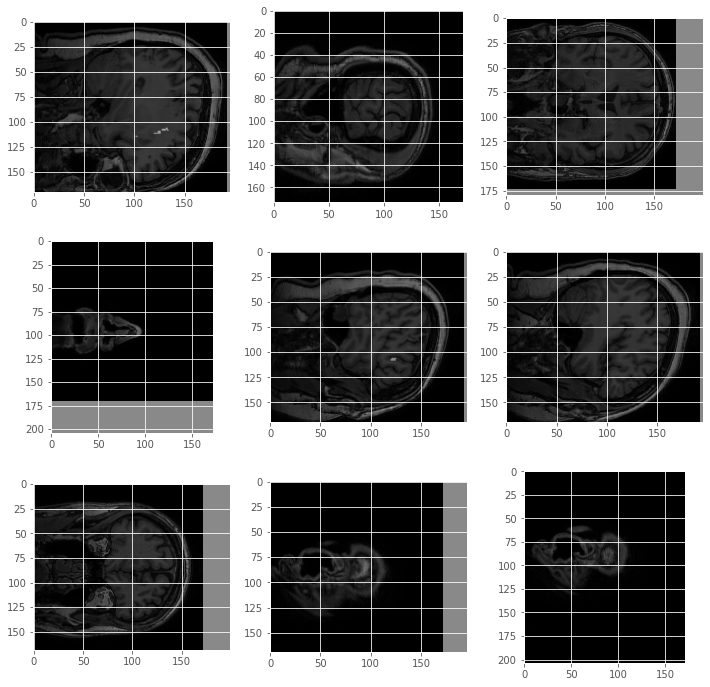

In [ ]:
plot_from_img_path(3, 3, image_filenames_train, mask_files )

# Create data frame and split data on train set, validation set and test set

In [ ]:
df = pd.DataFrame(data={'image_filenames_train': image_filenames_train, 'mask': mask_files })

df_train, df_test = train_test_split(df, test_size=0.1)

# Further split this val and train
df_train, df_val = train_test_split(df_train, test_size=0.2)

print(df_train.shape)
print(df_test.shape)
print(df_val.shape)

(2941, 2)
(409, 2)
(736, 2)


# Data genertator, data augmentation and adjust data

In [ ]:
# Referring Code From: https://github.com/zhixuhao/unet/blob/master/data.py
def train_generator(
    data_frame,
    batch_size,
    augmentation_dict,
    image_color_mode="rgb",
    mask_color_mode="grayscale",
    image_save_prefix="image",
    mask_save_prefix="mask",
    save_to_dir=None,
    target_size=(256, 256),
    seed=1,
):
    """
    can generate image and mask at the same time use the same seed for
    image_datagen and mask_datagen to ensure the transformation for image
    and mask is the same if you want to visualize the results of generator,
    set save_to_dir = "your path"
    """
    image_datagen = ImageDataGenerator(**augmentation_dict)
    mask_datagen = ImageDataGenerator(**augmentation_dict)

    image_generator = image_datagen.flow_from_dataframe(
        data_frame,
        x_col="image_filenames_train",
        class_mode=None,
        color_mode=image_color_mode,
        target_size=target_size,
        batch_size=batch_size,
        save_to_dir=save_to_dir,
        save_prefix=image_save_prefix,
        seed=seed,
    )

    mask_generator = mask_datagen.flow_from_dataframe(
        data_frame,
        x_col="mask",
        class_mode=None,
        color_mode=mask_color_mode,
        target_size=target_size,
        batch_size=batch_size,
        save_to_dir=save_to_dir,
        save_prefix=mask_save_prefix,
        seed=seed,
    )

    train_gen = zip(image_generator, mask_generator)
    
    # Final return Tuple after image Normalization and Diagnostics
    for (img, mask) in train_gen:
        img, mask = normalize_and_diagnose(img, mask)
        yield (img, mask)

In [ ]:
''' After mask Normalization if the value is <= 0.5 then that Mask 
will be considered a complete black one and does not have any lesion '''
def normalize_and_diagnose(img, mask):
    img = img / 255
    mask = mask / 255
    mask[mask > 0.5] = 1 #there is a lesion
    mask[mask <= 0.5] = 0 #nothing
    return(img, mask)

In [ ]:
EPOCHS = 25
BATCH_SIZE = 10
learning_rate = 1e-4
smooth=100

In [ ]:
model = unet()
model.summary

<bound method Model.summary of <keras.engine.functional.Functional object at 0x7f4cf6238210>>

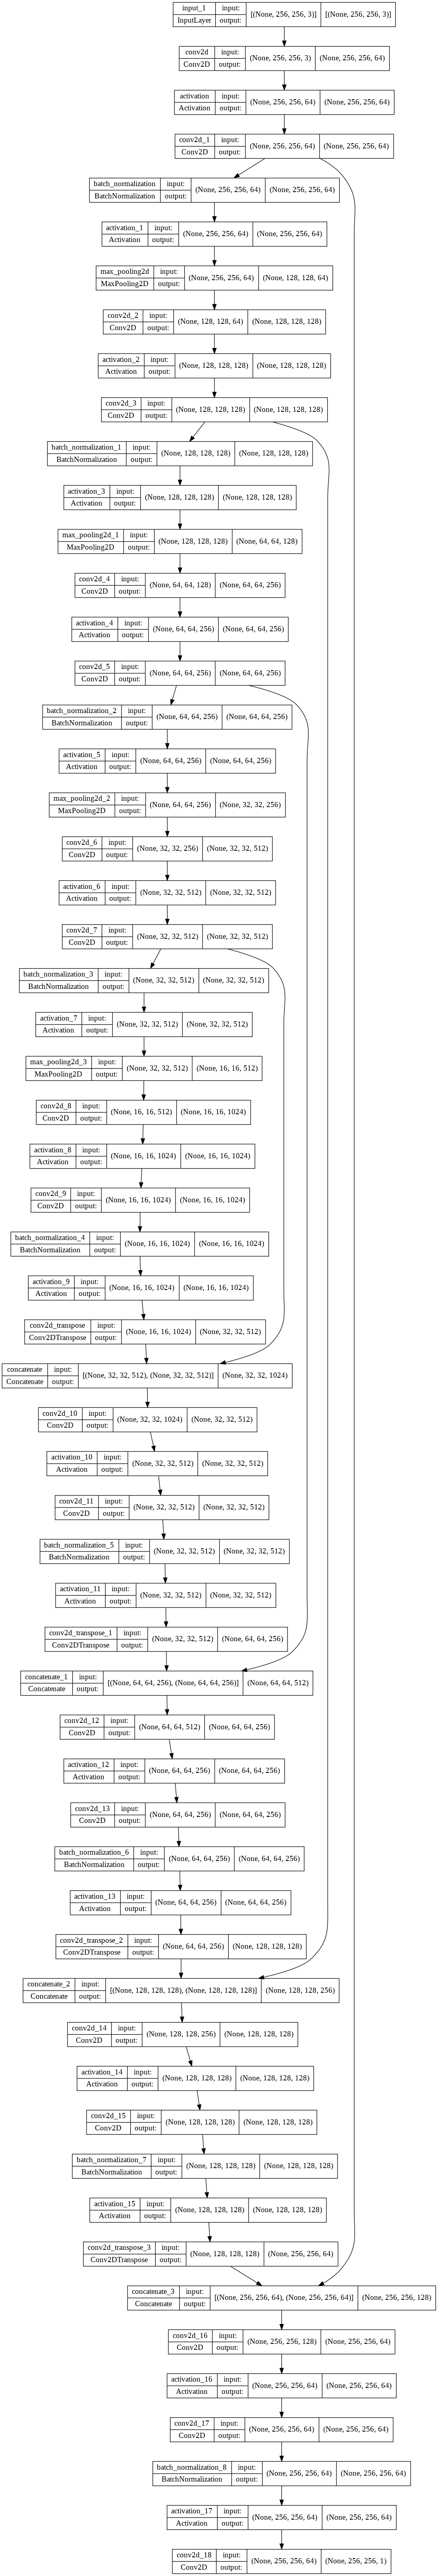

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
train_generator_param = dict(rotation_range=0.2,
                            width_shift_range=0.05,
                            height_shift_range=0.05,
                            shear_range=0.05,
                            zoom_range=0.05,
                            horizontal_flip=True,
                            fill_mode='nearest')

train_gen = train_generator(df_train, BATCH_SIZE,
                                train_generator_param,
                                target_size=(im_height, im_width))
    
test_gen = train_generator(df_val, BATCH_SIZE,
                                dict(),
                                target_size=(im_height, im_width))
    
model = unet(input_size=(im_height, im_width, 3))



decay_rate = learning_rate / EPOCHS

opt = Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=decay_rate, amsgrad=False)

model.compile(optimizer=opt, loss=dice_coefficients_loss, metrics=["binary_accuracy", iou, dice_coefficients])

callbacks = [ModelCheckpoint('unet.hdf5', verbose=1, save_best_only=True)]

history = model.fit(train_gen,
                    steps_per_epoch=len(df_train) / BATCH_SIZE, 
                    epochs=EPOCHS, 
                    callbacks=callbacks,
                    validation_data = test_gen,
                    validation_steps=len(df_val) / BATCH_SIZE)

Found 2941 validated image filenames.
Found 2941 validated image filenames.
Epoch 1/40
295/294 [==============================] - ETA: -2s - loss: -0.0196 - binary_accuracy: 0.7109 - iou: 0.0103 - dice_coefficients: 0.0197Found 736 validated image filenames.
Found 736 validated image filenames.

Epoch 1: val_loss improved from inf to -0.01092, saving model to unet.hdf5
294/294 [==============================] - 871s 3s/step - loss: -0.0196 - binary_accuracy: 0.7109 - iou: 0.0103 - dice_coefficients: 0.0197 - val_loss: -0.0109 - val_binary_accuracy: 0.9948 - val_iou: 0.0065 - val_dice_coefficients: 0.0110
Epoch 2/40
295/294 [==============================] - ETA: -1s - loss: -0.0257 - binary_accuracy: 0.8298 - iou: 0.0136 - dice_coefficients: 0.0257
Epoch 2: val_loss improved from -0.01092 to -0.02474, saving model to unet.hdf5
294/294 [==============================] - 359s 1s/step - loss: -0.0257 - binary_accuracy: 0.8298 - iou: 0.0136 - dice_coefficients: 0.0257 - val_loss: -0.0247 -